In [2]:


%load_ext autoreload
%autoreload 2
%load_ext line_profiler


import numpy as np
import DemandEstimation_v2 as DE
from tqdm.notebook import tqdm
from statsmodels.regression.linear_model import OLS 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt



#### Setting true parameters and simulating one period market

In [4]:
# setting parameters 

f=2 # Firms
j=2# Products
k=2 # Traits (of each product) 
data = DE.endog_data()
X, prod=data.simulate_product_traits(f,j,k, which_type = "Identical")
X = X.reshape(j*f, -1)

# True Parameters 
alpha = -0.02                # Price sensitivity
beta= np.array([1,2])        # Preference for traits 
mc = np.array([60,60, 70 ,40])           # Marginal costs of producing each product
theta = np.append(alpha,beta)  

# Simulating data: 
P = np.zeros((f*j)) +1               #Initital price vector
data.sim_data(P, theta, X, mc, prod, f, j)


TypeError: sim_data() missing 1 required positional argument: 'J'

In [5]:
# I could add shocks to production costs over time (ar(1) + noise). That would induce variation over time in prices. 
# I think when MC is perfectly known we lose one dimension of noise. Hence what is left is noise wrt. to demand. But the distribution is known and hence create the logit demand system. 

#### Simulating multiple markets

In [6]:
# setting parameters 

f=2 # Firms
j=2# Products
k=2 # Traits (of each product) 

data = DE.endog_data()
X, prod=data.simulate_product_traits(f,j,k, which_type = "Differentiated")
X = X.reshape(j*f, -1)

# True Parameters 
alpha = -2                # Price sensitivity
beta= np.array([2,2])        # Preference for traits 
theta = np.append(alpha,beta)  
cov = np.array([[1,0.5],[0.5,1]])
#cov = np.array([[1,0.0],[0.0,1]])
gamma = np.array([1,1])
T = 10
P0 = np.zeros((f*j)) +1               #Initital price vector

#mc=data.mc_sim(X, gamma,T=T, noise_type = "Triangular")

In [7]:
#P, S = data.sim_data_T(X, f, j, T, theta, gamma, cov, prod)
#S.min()
S = np.array(0) 
while S.min() == 0.0:
    P, S = data.sim_data_T(X, f, j, T, theta, gamma, cov, prod)
    print(S.min()==0.0)


TypeError: sim_data_T() missing 1 required positional argument: 'H'

#### Using OLS to solve the system: 
1) Divide by outside option and Log transform the system. 

In [8]:
P[:,9]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [9]:
# OLS: 
# But I do not have the outside option in my data... I can construct it easily. 
S0=(1-np.sum(S,axis=0))

index=np.log(S/S0).reshape(-1,1)

# OLS with endogenous prices
P1 = P.reshape(-1,1)
XX = np.hstack((P1, X.repeat(T, axis=0)))
#XX = XX[:,0:2]
resultsp=OLS(index,XX).fit()
resultsp.params

# OLS with MC instead



C:\Users\glh287\AppData\Local\Temp/ipykernel_13756/3970718755.py:5: RuntimeWarning: divide by zero encountered in log
  index=np.log(S/S0).reshape(-1,1)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 40

#### Using 2-step IV: 

In [10]:
check = np.array(np.arange(j*f))
Z = []
for firm, js in prod.items():
    not_f_prods=[j for j in check if j not in js ]
    
    Z_i = X[not_f_prods,:].mean(axis=0)
    
    Z.append(Z_i)
    
Z = np.array(Z) 

ZZ = Z.repeat(T, axis=0)
Piv1 = P.reshape(-1)


results1step=OLS(P1,ZZ).fit()
results1step.params

EP = (ZZ @ results1step.params).reshape(-1,1)

# Step 2 IV: 
ZX = np.hstack((EP, X.repeat(T, axis=0)))
#XX = XX[:,0:2]
resultsIV=OLS(index,ZX).fit()
resultsIV.params



ValueError: endog and exog matrices are different sizes

### Doing a simulation study: 

In [42]:
def sim_study(Q,cov, Type = "OLS", Consts = False):
    """
    Type - options "OLS", "IV"
    """

    # No. of Firms, products and traits: 
    f=2 # Firms
    j=2 # Products
    k=3 # Traits (of each product) 
    
    # True Parameters 
    alpha = -5                      # Price sensitivity
    beta= np.array([2,2,4])         # Preference for traits 
    theta = np.append(alpha,beta)   
    gamma = np.array([1,1,4])       # Production costs of traits 

    #cov = np.array([[1,0.5],[0.5,1]])
    T = 50

    if Type == "OLS":
        if Consts == True: 
            parameters = np.zeros((Q,1 + k*2 + f*j*2)) + np.nan
        else:
            parameters = np.zeros((Q,k + 1)) + np.nan

    elif Type == "IV":
        parameters = np.zeros((Q, k+1))

    for q in tqdm(range(Q)): 
        try:
            
            data = DE.endog_data()
            X, prod=data.simulate_product_traits(f,j,k, which_type = "Differentiated")
            H = data.hadamard(f*j,prod)
            X = X.reshape(j*f, -1)

            # Simulate data 
            S = np.array(0) 
            while S.min() == 0.0:
                P, S = data.sim_data_T(X, f, j, T, theta, gamma, cov, prod, H, disable = True)
            S.min()
            
            # constructing instruments: 
            # Not implemented

            #Estimation: 
            if Type == "OLS": 
                S0=(1-np.sum(S,axis=0))

                index=np.log(S/S0).reshape(-1,1)

                # OLS with endogenous prices
                P1 = P.reshape(-1,1)

                if Consts == True: 
                    j_const = np.identity(f*j).repeat(T, axis=0)
                    XX = np.hstack((P1, X.repeat(T, axis=0),j_const))
                else: 
                    XX = np.hstack((P1, X.repeat(T, axis=0)))

                resultsp=OLS(index,XX).fit()
                results = resultsp.params
            
                parameters[q,:] = results
            
            elif Type == "IV":
                S0=(1-np.sum(S,axis=0))

                index=np.log(S/S0).reshape(-1,1)
                

                check = np.array(np.arange(j*f))
                Z = []
                for firm, js in prod.items():
                    not_f_prods=[j for j in check if j not in js ]

                    Z_i = X[not_f_prods,:].mean(axis=0)   #(k,)
                    #print("shape of Z_i",Z_i.shape)

                    Z.append(Z_i)

                Z = np.array(Z)                            #(f,k)
                #print("shape of Z:", Z.shape)
                ZZ = Z.repeat(T*j, axis=0)                 #(T*f*j,k)
                Piv1 = P.reshape(-1)

                # This will not work since it is looking at a firm level. But I need to create j instruments for each firm. 
                S = []
                for firm, cs in prod.items():
                    for c in cs: 
                        same_firm_not_j_prods=[i for i in cs if i != c]
                        S_i=X[same_firm_not_j_prods,:].mean(axis=0)

                        S.append(S_i)
                S =np.array(S)
                SS = S.repeat(T, axis=0)
                #print(S)
                #print("shape of S:",SS.shape, "shape of Z", ZZ.shape)

                ZS = np.hstack((ZZ, ZZ**2, SS, SS**2))
                #print(ZS.shape)
                
                results1step=OLS(Piv1,ZZ).fit()
                results1step.params

                EP = (ZZ @ results1step.params).reshape(-1,1)

                # Step 2 IV: 
                ZX = np.hstack((EP, X.repeat(T, axis=0)))
                #XX = XX[:,0:2]
                resultsIV=OLS(index,ZX).fit()
            
                parameters[q,:] = resultsIV.params
                

        except np.linalg.LinAlgError: 
            break
    return parameters




    

In [43]:

P=2000
cov = np.array([[1,0.8],[0.8,1]])
corr=sim_study(P,cov, Type = "OLS", Consts = False)
corr_IV = sim_study(P, cov, Type = "IV")


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [44]:

cov = np.array([[1,0.0],[0.0,1]])
wo_corr = sim_study(P,cov, Type = "OLS", Consts = False)
wo_corr_IV = sim_study(P,cov, Type = "IV")


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [45]:
wo_corr_pd = pd.DataFrame(wo_corr)
wo_corr_pd_IV = pd.DataFrame(wo_corr_IV)
corr_pd = pd.DataFrame(corr)
corr_pd_IV = pd.DataFrame(corr_IV)


In [46]:
pd.DataFrame([wo_corr_pd.mean(axis=0),wo_corr_pd_IV.mean(axis=0), corr_pd.mean(axis=0), corr_pd_IV.mean(axis=0)])

,0,1,2,3
0,-5.001026,2.018575,2.030955,3.981454
1,-2.617204,-1.697677,-1.936883,-5.436798
2,-4.522590,1.420865,1.412941,2.056116
3,2.133435,-36.954088,-0.318548,-13.040739


C:\Users\glh287\AppData\Local\Temp/ipykernel_13576/2011577078.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


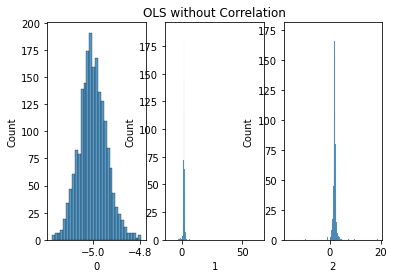

In [40]:
#corr_pd = corr_pd.loc[~(corr_pd==0).all(axis=1)]


fig, ax =plt.subplots(1,3)
sns.histplot(wo_corr_pd[0], ax=ax[0])
sns.histplot(wo_corr_pd[1], ax=ax[1]).set(title='OLS without Correlation')
sns.histplot(wo_corr_pd[2], ax=ax[2])


fig.show()

C:\Users\glh287\AppData\Local\Temp/ipykernel_13576/2755507471.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


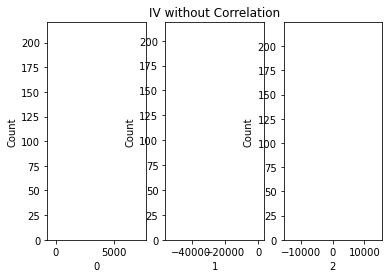

In [47]:
#corr_pd = corr_pd.loc[~(corr_pd==0).all(axis=1)]


fig, ax =plt.subplots(1,3)
sns.histplot(corr_pd_IV[0], ax=ax[0])
sns.histplot(corr_pd_IV[1], ax=ax[1]).set(title='IV without Correlation')
sns.histplot(corr_pd_IV[2], ax=ax[2])


fig.show()

C:\Users\glh287\AppData\Local\Temp/ipykernel_13576/373389710.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


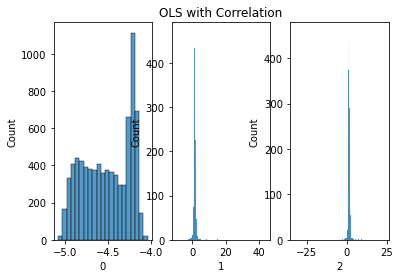

In [22]:
#corr_pd = corr_pd.loc[~(corr_pd==0).all(axis=1)]

fig, ax =plt.subplots(1,3)
sns.histplot(corr_pd[0], ax=ax[0])
sns.histplot(corr_pd[1], ax=ax[1]).set(title='OLS with Correlation')
sns.histplot(corr_pd[2], ax=ax[2])

fig.show()

In [31]:
wo_corr_pd.mean()

0   -4.999780
1    1.989975
2    2.007524
3    3.994368
dtype: float64

C:\Users\glh287\AppData\Local\Temp/ipykernel_13576/1024738073.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


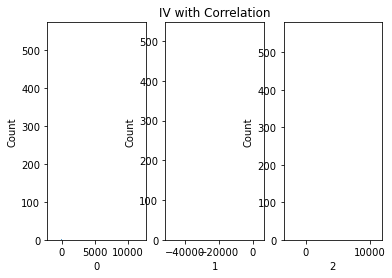

In [23]:
#corr_pd = corr_pd.loc[~(corr_pd==0).all(axis=1)]

fig, ax =plt.subplots(1,3)
sns.histplot(corr_pd_IV[0], ax=ax[0])
sns.histplot(corr_pd_IV[1], ax=ax[1]).set(title='IV with Correlation')
sns.histplot(corr_pd_IV[2], ax=ax[2])

fig.show()

In [99]:
corr_pd_IV.mean()

0    -1.941582
1     1.834832
2    -5.530314
3   -12.204213
dtype: float64

C:\Users\glh287\AppData\Local\Temp/ipykernel_13756/1170351877.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


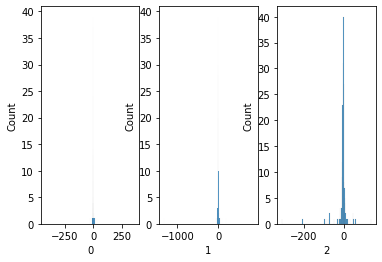

In [60]:
corr_pd = pd.DataFrame(corr_IV)
corr_pd = corr_pd.loc[~(corr_pd==0).all(axis=1)]

fig, ax =plt.subplots(1,3)
sns.histplot(corr_pd[0], ax=ax[0])
sns.histplot(corr_pd[1], ax=ax[1])
sns.histplot(corr_pd[2], ax=ax[2])

fig.show()

In [61]:
corr_pd.mean()

0    -1.328259
1    -6.079788
2    -6.126337
3   -12.989173
dtype: float64

In [768]:
omega.shape

(4, 10)

In [779]:
cov = np.array([[1,0.8],[0.8,1]])

In [780]:
omega, sigma=data.cov_term(f,j,T, cov = cov)

np.corrcoef(omega.reshape(-1),sigma.reshape(-1))

array([[1.        , 0.85872036],
       [0.85872036, 1.        ]])

### Adding Instruments: 
BLP Instruments consist of: 
 - average attributes of own firm other products characteristics (if j = 1, then this instrument is invalid)
 - average attributes of other firm product characteristics.     


NameError: name 'X' is not defined

### Results
Unexpected result since OLS is able to recover the parameters of the model exactly. Right now the model is estimated Must be because pr

In [242]:
X.repeat(200, axis=0).shape

(1600, 2)

In [106]:
X.repeat(200, axis=0).shape


(800, 2)

In [26]:
mean = [0,0]
cov  = np.array([[1,0.1],[0.1,1]])
test=np.random.multivariate_normal(mean,cov,size = (f,j) )
test.shape

(5, 5, 2)

In [27]:
cov

array([[1. , 0.1],
       [0.1, 1. ]])

In [154]:
np.random.multivariate_normal([0,0],cov, size = (f*j)).shape

(50, 2)

In [24]:
x = np.array([1,1,1,0])
np.maximum(x, 0.5)

array([1. , 1. , 1. , 0.5])

In [ ]:



def sim_study_IV(Q,cov):
    parameters = np.zeros((Q,3))#+4*2))
    for q in tqdm(range(Q)): 
        try:
            f=2 # Firms
            j=3 # Products
            k=2 # Traits (of each product) 

            data = DE.endog_data()
            X, prod=data.simulate_product_traits(f,j,k, which_type = "Differentiated")
            X = X.reshape(j*f, -1)
            H = data.hadamard(f*j,prod)

            # True Parameters 
            alpha = -1                # Price sensitivity
            beta= np.array([1,1])        # Preference for traits 
            theta = np.append(alpha,beta)  
            #cov = np.array([[1,0.5],[0.5,1]])

            gamma = -np.array([1,1,1])
            T = 20
            P0 = np.zeros((f*j)) +1               #Initital price vector

            # Simulate data 
            S = np.array(0) 
            while S.min() == 0.0:
                P, S = data.sim_data_T(X, f, j, T, theta, gamma, cov, prod, H, disable = True)
            S.min()
            
            # constructing instruments: 
            # Not implemented

            #Estimation: 
            S0=(1-np.sum(S,axis=0))

            index=np.log(S/S0).reshape(-1,1)
            

            check = np.array(np.arange(j*f))
            Z = []
            for firm, js in prod.items():
                not_f_prods=[j for j in check if j not in js ]

                Z_i = X[not_f_prods,:].mean(axis=0)

                Z.append(Z_i)

            Z = np.array(Z) 

            ZZ = Z.repeat(T, axis=0)
            Piv1 = P.reshape(-1)


            results1step=OLS(Piv1,ZZ).fit()
            results1step.params

            EP = (ZZ @ results1step.params).reshape(-1,1)

            # Step 2 IV: 
            ZX = np.hstack((EP, X.repeat(T, axis=0)))
            #XX = XX[:,0:2]
            resultsIV=OLS(index,ZX).fit()
        
            parameters[q,:] = resultsIV.params
            
        except np.linalg.LinAlgError: 
            continue
    return parameters




    